### PREDICTION CHALLENGE TASK II & III

## 1. Import Libraries, Data and Preparation

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans,DBSCAN
from statsmodels.tsa.statespace.sarimax import SARIMAX
import math

In [3]:
data = pd.read_csv('Clustering_Data.csv')
data.head()


,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,gender,start_time,stop_time,tripduration_min,age,start_cluster_20,end_cluster_20
0,72.0,40.767272,-73.993929,505.0,40.749013,-73.988484,31956,1,1,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186,16.17,26,17,4
1,72.0,40.767272,-73.993929,3255.0,40.750585,-73.994685,32536,1,1,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341,12.05,49,17,17
2,72.0,40.767272,-73.993929,525.0,40.755942,-74.002116,16069,1,1,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172,8.27,62,17,17
3,72.0,40.767272,-73.993929,447.0,40.763707,-73.985162,31781,1,1,2018-01-01 15:40:13.372,2018-01-01 15:45:20.191,5.10,44,17,17
4,72.0,40.767272,-73.993929,3356.0,40.774667,-73.984706,30319,1,1,2018-01-01 18:14:51.568,2018-01-01 18:19:57.642,5.10,26,17,1


In [4]:
# Convert start_time and stop_time columns to datetime
data['start_time'] = pd.to_datetime(data['start_time'], format="%Y-%m-%d %H:%M:%S.%f")
data['stop_time'] = pd.to_datetime(data['stop_time'], format="%Y-%m-%d %H:%M:%S.%f")

data.head()


,start_station_id,start_station_latitude,start_station_longitude,end_station_id,end_station_latitude,end_station_longitude,bikeid,usertype,gender,start_time,stop_time,tripduration_min,age,start_cluster_20,end_cluster_20
0,72.0,40.767272,-73.993929,505.0,40.749013,-73.988484,31956,1,1,2018-01-01 13:50:57.434,2018-01-01 14:07:08.186,16.17,26,17,4
1,72.0,40.767272,-73.993929,3255.0,40.750585,-73.994685,32536,1,1,2018-01-01 15:33:30.182,2018-01-01 15:45:33.341,12.05,49,17,17
2,72.0,40.767272,-73.993929,525.0,40.755942,-74.002116,16069,1,1,2018-01-01 15:39:18.337,2018-01-01 15:47:35.172,8.27,62,17,17
3,72.0,40.767272,-73.993929,447.0,40.763707,-73.985162,31781,1,1,2018-01-01 15:40:13.372,2018-01-01 15:45:20.191,5.10,44,17,17
4,72.0,40.767272,-73.993929,3356.0,40.774667,-73.984706,30319,1,1,2018-01-01 18:14:51.568,2018-01-01 18:19:57.642,5.10,26,17,1


## 2. Pickups and Dropoffs Prediction 

### 2.1 Time Series Analysis Model

Given a specific cluster, we filter the data by keeping only trips whose starting station belongs to the named cluster. You can use the clusters_map.html that we created in the **Prediction_Challenge_Clustering.ipynb** notebook in order to decide what cluster you want to predict pickups and demands.

In [28]:
#We suggest clusters 2,3,15
target_clusters = [15]

data_filtered = data[data['start_cluster_20'].isin(target_clusters)].copy()

data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2026240 entries, 10984 to 17480615
Data columns (total 15 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   start_station_id         float64       
 1   start_station_latitude   float64       
 2   start_station_longitude  float64       
 3   end_station_id           float64       
 4   end_station_latitude     float64       
 5   end_station_longitude    float64       
 6   bikeid                   int64         
 7   usertype                 int64         
 8   gender                   int64         
 9   start_time               datetime64[ns]
 10  stop_time                datetime64[ns]
 11  tripduration_min         float64       
 12  age                      int64         
 13  start_cluster_20         int64         
 14  end_cluster_20           int64         
dtypes: datetime64[ns](2), float64(7), int64(6)
memory usage: 247.3 MB


### 2.1.1 Pickups Prediction

In [29]:
# Create pickup hour and date columns
data_filtered['pickup_hour'] = data_filtered['start_time'].dt.hour
data_filtered['date'] = data_filtered['start_time'].dt.date

data_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Index: 2026240 entries, 10984 to 17480615
Data columns (total 17 columns):
 #   Column                   Dtype         
---  ------                   -----         
 0   start_station_id         float64       
 1   start_station_latitude   float64       
 2   start_station_longitude  float64       
 3   end_station_id           float64       
 4   end_station_latitude     float64       
 5   end_station_longitude    float64       
 6   bikeid                   int64         
 7   usertype                 int64         
 8   gender                   int64         
 9   start_time               datetime64[ns]
 10  stop_time                datetime64[ns]
 11  tripduration_min         float64       
 12  age                      int64         
 13  start_cluster_20         int64         
 14  end_cluster_20           int64         
 15  pickup_hour              int32         
 16  date                     object        
dtypes: datetime64[ns](2), float

In [30]:
# Count pickups per hour, per day (for one cluster)
cluster_hourly = (
    data_filtered
    .groupby(['date', 'pickup_hour'])
    ['start_station_id']
    .size()
    .reset_index()
    .rename(columns={'start_station_id': 'pickups'})
)
cluster_hourly.head()

,date,pickup_hour,pickups
0,2018-01-01,0,15
1,2018-01-01,1,28
2,2018-01-01,2,12
3,2018-01-01,3,12
4,2018-01-01,4,3


In [31]:
cluster_hourly['datetime'] = pd.to_datetime(
    cluster_hourly['date'].astype(str) + ' ' +
    cluster_hourly['pickup_hour'].astype(str) + ':00:00'
)
cluster_hourly = cluster_hourly.sort_values('datetime')

In [32]:
# Ensure datetime index and hourly frequency
chd = (
    cluster_hourly
    .set_index('datetime')
    .sort_index()
    .asfreq('H')              # guarantees continuous hourly timeline
    .fillna({'pickups': 0})  # fill missing hours if any
)

# Make sure we only keep 2018 samples
chd_2018 = chd.loc['2018-01-01':'2018-12-31 23:00']

# Train: Jan–Oct 2018
train_data = chd.loc['2018-01-01':'2018-10-31 23:00', 'pickups']

# Test: Nov–Dec 2018
test_data  = chd.loc['2018-11-01 00:00':'2018-12-31 23:00', 'pickups']

C:\Users\billy\AppData\Local\Temp\ipykernel_17908\495717343.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .asfreq('H')              # guarantees continuous hourly timeline


C:\Users\billy\AppData\Local\Temp\ipykernel_17908\430030329.py:12: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_index = pd.date_range(start=last_train_datetime + pd.Timedelta(hours=1), periods=24, freq='H')


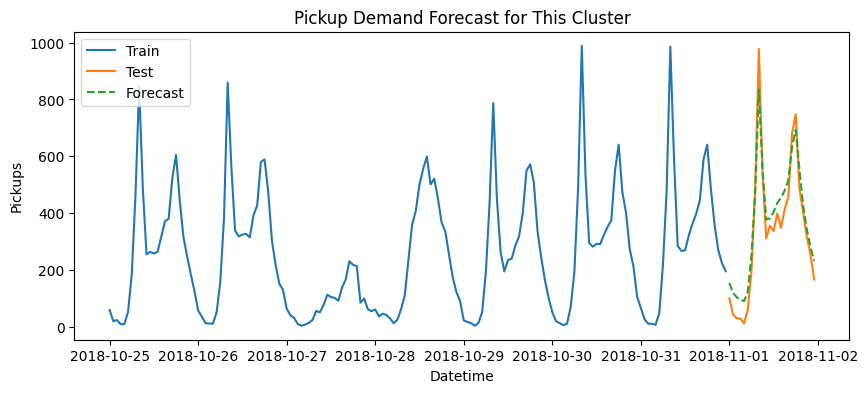

In [33]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

# Fit ARIMA model for this cluster
model = SARIMAX(train_data, order=(1, 1, 1), seasonal_order=(1, 1, 1, 24))
fitted = model.fit(disp=False)

# Forecast next 24 hours
forecast = fitted.forecast(steps=24)

# Create forecast datetime index
last_train_datetime = train_data.index[-1]
forecast_index = pd.date_range(start=last_train_datetime + pd.Timedelta(hours=1), periods=24, freq='H')

# Plot results
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.plot(train_data[-24*7:], label='Train')
plt.plot(test_data[:24], label='Test')
plt.plot(forecast_index, forecast, '--', label='Forecast')
plt.title('Pickup Demand Forecast for This Cluster')
plt.xlabel('Datetime')
plt.ylabel('Pickups')
plt.legend()
plt.show()

Mean Absolute Error for Pickups Prediction

In [34]:
y_true = chd_2018.loc['2018-11-01','pickups']
y_pred = forecast

mae = np.mean(np.abs(y_true - y_pred))
print("Mean Absolute Error is",mae)

rmse = np.sqrt(np.mean((y_true - y_pred)**2))
print("RMSE is",rmse)

Mean Absolute Error is 57.27050398731557
RMSE is 64.04297205997551


### 2.1.2 Dropoffs Prediction

In [16]:
data_filtered_dropoffs = data[data['end_cluster_20'].isin(target_clusters)].copy()

data_filtered_dropoffs['dropoff_hour'] = data_filtered['stop_time'].dt.hour.astype("Int32")
data_filtered_dropoffs['date'] = data_filtered['stop_time'].dt.date

data_filtered_dropoffs.info()

<class 'pandas.core.frame.DataFrame'>
Index: 988322 entries, 1365 to 17480669
Data columns (total 17 columns):
 #   Column                   Non-Null Count   Dtype         
---  ------                   --------------   -----         
 0   start_station_id         988322 non-null  float64       
 1   start_station_latitude   988322 non-null  float64       
 2   start_station_longitude  988322 non-null  float64       
 3   end_station_id           988322 non-null  float64       
 4   end_station_latitude     988322 non-null  float64       
 5   end_station_longitude    988322 non-null  float64       
 6   bikeid                   988322 non-null  int64         
 7   usertype                 988322 non-null  int64         
 8   gender                   988322 non-null  int64         
 9   start_time               988322 non-null  datetime64[ns]
 10  stop_time                988322 non-null  datetime64[ns]
 11  tripduration_min         988322 non-null  float64       
 12  age             

In [17]:
# Count dropoffs per hour, per day (for this cluster)
cluster_hourly_drops = (
    data_filtered_dropoffs
    .groupby(['date', 'dropoff_hour'])
    ['end_station_id']
    .size()
    .reset_index()
    .rename(columns={'end_station_id': 'dropoffs'})
)


In [18]:
cluster_hourly_drops['datetime'] = pd.to_datetime(
    cluster_hourly_drops['date'].astype(str) + ' ' +
    cluster_hourly_drops['dropoff_hour'].astype(str) + ':00:00'
)
cluster_hourly_drops = cluster_hourly_drops.sort_values('datetime')
cluster_hourly_drops.head()

,date,dropoff_hour,dropoffs,datetime
0,2018-01-01,0,2,2018-01-01 00:00:00
1,2018-01-01,1,3,2018-01-01 01:00:00
2,2018-01-01,2,4,2018-01-01 02:00:00
3,2018-01-01,3,2,2018-01-01 03:00:00
4,2018-01-01,4,3,2018-01-01 04:00:00


In [19]:
# Ensure datetime index and hourly frequency
chd_drop = (
    cluster_hourly_drops
    .set_index('datetime')
    .sort_index()
    .asfreq('H')              # guarantees continuous hourly timeline
    .fillna({'dropoffs': 0})  # fill missing hours if any
)

# Keep only 2018 samples
chd_2018_drop = chd_drop.loc['2018-01-01':'2018-12-31 23:00']

# Train: Jan–Oct 2018
train_data_drop = chd_2018_drop.loc['2018-01-01':'2018-10-31 23:00', 'dropoffs']
print(train_data_drop)

# Test: Nov–Dec 2018
test_data_drop  = chd_2018_drop.loc['2018-11-01 00:00':'2018-12-31 23:00', 'dropoffs']


datetime
2018-01-01 00:00:00      2.0
2018-01-01 01:00:00      3.0
2018-01-01 02:00:00      4.0
2018-01-01 03:00:00      2.0
2018-01-01 04:00:00      3.0
                       ...  
2018-10-31 19:00:00    104.0
2018-10-31 20:00:00     64.0
2018-10-31 21:00:00     59.0
2018-10-31 22:00:00     45.0
2018-10-31 23:00:00     28.0
Freq: h, Name: dropoffs, Length: 7296, dtype: float64


C:\Users\billy\AppData\Local\Temp\ipykernel_17908\490359717.py:6: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  .asfreq('H')              # guarantees continuous hourly timeline


c:\MSc DTU\Semester 1\00. Introduction to BA\Assignment\city-bike\CityBikesVenv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\MSc DTU\Semester 1\00. Introduction to BA\Assignment\city-bike\CityBikesVenv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\billy\AppData\Local\Temp\ipykernel_17908\1894603461.py:10: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  forecast_drop_index = pd.date_range(start=train_data_drop.index[-1] + pd.Timedelta(hours=1),periods=24, freq='H')


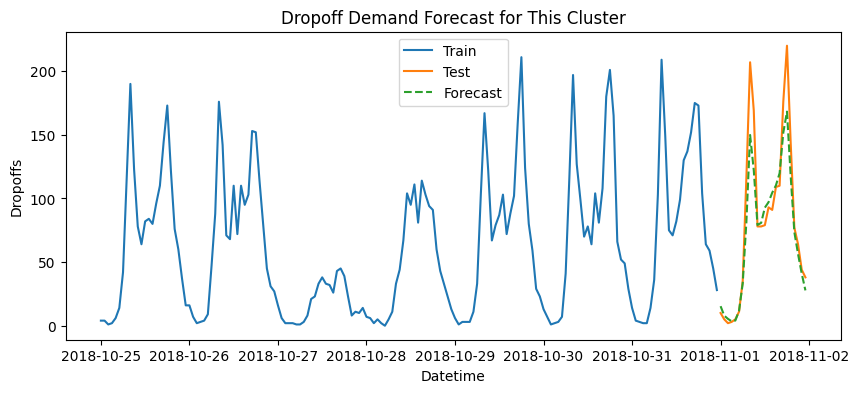

In [20]:
# Fit ARIMA model for this cluster
model = SARIMAX(train_data_drop, order=(1, 1, 1), seasonal_order=(1, 1, 1, 24))
fitted = model.fit(disp=False)

# Forecast next 24 hours
forecast_drop = fitted.forecast(steps=24)

# Create forecast datetime index
last_train_datetime = train_data_drop.index[-1]
forecast_drop_index = pd.date_range(start=train_data_drop.index[-1] + pd.Timedelta(hours=1),periods=24, freq='H')

# Plot results
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.plot(train_data_drop[-24*7:], label='Train')
plt.plot(test_data_drop[:24], label='Test')
plt.plot(forecast_drop_index, forecast_drop, '--', label='Forecast')
plt.title('Dropoff Demand Forecast for This Cluster')
plt.xlabel('Datetime')
plt.ylabel('Dropoffs')
plt.legend()
plt.show()

In [21]:
y_true = chd_2018_drop.loc['2018-11-01','dropoffs']
y_pred = forecast

mae = np.mean(np.abs(y_true - y_pred))
print("Mean Absolute Error is",mae)

rmse = np.sqrt(np.mean((y_true - y_pred)**2))
print("RMSE is",rmse)

Mean Absolute Error is 54.98733846308429
RMSE is 72.28764312085944


## 3. Neural Networks Model

## 4. Model Comparison

## 5. Net Flow Prediction

This implementation is more interactive. We let the user pick the date they want to predict the number of bikes that need to be repositioned. Then, we dynamically select train and test dataset and use timeseries to find the hourly net flow of the cluster.

In [35]:
hourly_2018_pickups = chd_2018.loc['2018-01-01':'2018-12-31 23:00','pickups']
hourly_2018_dropoffs = chd_2018_drop.loc['2018-01-01':'2018-12-31 23:00','dropoffs']
hourly_2018_pickups_dropoffs = pd.concat([hourly_2018_pickups,hourly_2018_dropoffs], axis=1)
hourly_2018_pickups_dropoffs.head()

,pickups,dropoffs
datetime,,
2018-01-01 00:00:00,15.0,2.0
2018-01-01 01:00:00,28.0,3.0
2018-01-01 02:00:00,12.0,4.0
2018-01-01 03:00:00,12.0,2.0
2018-01-01 04:00:00,3.0,3.0


In the following user prompt, you should type '2018-11-01', to continue with the same split of train/test data as we have used in **2.1.1 1 & 2.1.2**. Feel free to experiment with different dates, as well. 

In [38]:
# Prompt the user to input the date
date_input = input("Enter the date for which you want to predict reposition needs (2018-MM-DD): ")

# Parse the input as a datetime
import datetime
try:
    target_date = datetime.datetime.strptime(date_input, "%Y-%m-%d").date()
    print(f"Processing reposition needs for: {target_date}")
except ValueError:
    print("Invalid date format. Please enter the date in YYYY-MM-DD format.")

Invalid date format. Please enter the date in YYYY-MM-DD format.


In [37]:
# Train data: Strictly before the given date
# Test data: Includes all dates from the input date and after
train_net_pick = hourly_2018_pickups_dropoffs.loc[hourly_2018_pickups_dropoffs.index < date_input,'pickups']
test_net_pick = hourly_2018_pickups_dropoffs.loc[hourly_2018_pickups_dropoffs.index >= date_input,'pickups']

train_net_drop = hourly_2018_pickups_dropoffs.loc[hourly_2018_pickups_dropoffs.index < date_input,'dropoffs']
test_net_drop = hourly_2018_pickups_dropoffs.loc[hourly_2018_pickups_dropoffs.index >= date_input,'dropoffs']


# Fit ARIMA model for this cluster
model1 = SARIMAX(train_net_pick, order=(1, 1, 1), seasonal_order=(1, 1, 1, 24))
fitted1 = model1.fit(disp=False)

model2 = SARIMAX(train_net_drop, order=(1, 1, 1), seasonal_order=(1, 1, 1, 24))
fitted2 = model2.fit(disp=False)

# Forecast next 24 hours pickups and dropoffs
fc_pickups = fitted1.forecast(steps=24)
fc_dropoffs = fitted2.forecast(steps=24)


c:\MSc DTU\Semester 1\00. Introduction to BA\Assignment\city-bike\CityBikesVenv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'
c:\MSc DTU\Semester 1\00. Introduction to BA\Assignment\city-bike\CityBikesVenv\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


In [39]:
picks_forecast_df = pd.DataFrame(fc_pickups)
picks_forecast_df.columns = ['pickups']
picks_forecast_df.index.name = 'datetime'
#picks_forecast_df.info()

drops_forecast_df = pd.DataFrame(fc_dropoffs)
drops_forecast_df.columns = ['dropoffs']
drops_forecast_df.index.name = 'datetime'
#drops_forecast_df.info()

# Combine forecasts into one DataFrame
forecast_next_day = pd.concat([picks_forecast_df, drops_forecast_df], axis=1)
forecast_next_day

,pickups,dropoffs
datetime,,
2018-05-15 00:00:00,69.945931,13.881229
2018-05-15 01:00:00,49.551589,9.437835
2018-05-15 02:00:00,39.009459,7.516812
2018-05-15 03:00:00,34.216984,6.526415
2018-05-15 04:00:00,33.235034,6.609992
2018-05-15 05:00:00,58.785935,12.447198
2018-05-15 06:00:00,149.871178,30.657925
2018-05-15 07:00:00,337.913641,61.855167
2018-05-15 08:00:00,634.394736,116.407576


In [40]:
# Calculate net flow: pickups = departures
net_flow = forecast_next_day['pickups'] - forecast_next_day['dropoffs']
forecast_next_day['net'] = net_flow
forecast_next_day



,pickups,dropoffs,net
datetime,,,
2018-05-15 00:00:00,69.945931,13.881229,56.064702
2018-05-15 01:00:00,49.551589,9.437835,40.113753
2018-05-15 02:00:00,39.009459,7.516812,31.492647
2018-05-15 03:00:00,34.216984,6.526415,27.690569
2018-05-15 04:00:00,33.235034,6.609992,26.625042
2018-05-15 05:00:00,58.785935,12.447198,46.338738
2018-05-15 06:00:00,149.871178,30.657925,119.213253
2018-05-15 07:00:00,337.913641,61.855167,276.058474
2018-05-15 08:00:00,634.394736,116.407576,517.987161


In [41]:
mask = forecast_next_day.index.date == target_date
day_netflow = forecast_next_day.loc[mask, 'net'].max()

# Required bikes at start of day
required_bikes = math.ceil(max(0, day_netflow))
print(f"Number of bikes to reposition on {target_date} is: {required_bikes}")

Number of bikes to reposition on 2018-05-15 is: 518
